In [122]:
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import LidarPointCloud
from transformers import ViTModel, ViTImageProcessor
import torch
from PIL import Image
import numpy as np
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch_geometric.nn import PointNetConv
from torch_geometric.data import Data
from torch_geometric.nn.pool import knn_graph
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score



nusc = NuScenes(version='v1.0-mini', dataroot='../3Dperc_p2/nuscenes', verbose=True)


Loading NuScenes tables for version v1.0-mini...
Loading nuScenes-lidarseg...
Loading nuScenes-panoptic...
32 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
404 lidarseg,
404 panoptic,
Done loading in 0.716 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [123]:
# Definisci l'encoder PointNet per i dati LiDAR
class PointNetEncoder(torch.nn.Module):
    def __init__(self):
        super(PointNetEncoder, self).__init__()
        self.conv1 = PointNetConv(local_nn=torch.nn.Sequential(
            torch.nn.Linear(3, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 256)
        ))
        self.conv2 = PointNetConv(local_nn=torch.nn.Sequential(
            torch.nn.Linear(256 + 3, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 1024)
        ))
        self.fc = torch.nn.Linear(1024, 256)

    def forward(self, pos, edge_index):
        x = F.relu(self.conv1(None, pos, edge_index))
        x = F.relu(self.conv2(x, pos, edge_index))
        x = torch.max(x, dim=0)[0]
        x = self.fc(x)
        x = x.view(1, -1)
        return x

In [124]:
# Funzione per processare un singolo sample
def process_sample(sample, image_processor, vision_model, lidar_encoder, fusion_layer):
    try:
        # Estrai i dati dell'immagine
        camera_token = sample['data']['CAM_FRONT']
        image_path = nusc.get_sample_data_path(camera_token)
        image = Image.open(image_path).convert('RGB')
        image_tensor = image_processor(images=image, return_tensors="pt")["pixel_values"]

        # Estrai i dati LiDAR
        lidar_token = sample['data']['LIDAR_TOP']
        lidar_path = nusc.get_sample_data_path(lidar_token)
        lidar_points = LidarPointCloud.from_file(lidar_path)
        lidar_tensor = torch.tensor(lidar_points.points[:3, :].T, dtype=torch.float32)

        # Controlla la forma dei dati LiDAR
        if lidar_tensor.ndim != 2 or lidar_tensor.size(1) != 3:
            raise ValueError(f"lidar_tensor deve avere la forma [num_points, 3], trovato {lidar_tensor.shape}")

        # Calcola gli embedding dell'immagine
        vision_outputs = vision_model(pixel_values=image_tensor)
        image_embedding = vision_outputs.last_hidden_state[:, 0, :]

        # Calcola gli embedding LiDAR
        edge_index = knn_graph(lidar_tensor, k=5)
        lidar_embedding = lidar_encoder(lidar_tensor, edge_index)

        # Controlla la forma degli embedding
        if lidar_embedding.shape != (1, 256):
            raise ValueError(f"lidar_embedding deve avere forma [1, 256], trovato {lidar_embedding.shape}")
        if image_embedding.shape[1] != vision_model.config.hidden_size:
            raise ValueError(f"image_embedding deve avere dimensione {vision_model.config.hidden_size}, trovato {image_embedding.shape}")

        # Fusione degli embedding
        fused_embedding = fusion_layer(torch.cat((image_embedding, lidar_embedding), dim=1))

        return fused_embedding.detach().numpy()
    except Exception as e:
        print(f"Errore nel processare il sample: {e}")
        return None

In [125]:
# Definizione del modello di classificazione
class FusionClassifier(torch.nn.Module):
    def __init__(self, input_size, num_classes):
        super(FusionClassifier, self).__init__()
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(input_size, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.fc(x)
        return x  # Output dei logits

In [126]:
# Funzione per processare un singolo sample e ottenere embedding
def process_sample_with_embeddings(sample, image_processor, vision_model, lidar_encoder, fusion_layer):
    try:
        # Estrai i dati dell'immagine
        camera_token = sample['data']['CAM_FRONT']
        image_path = nusc.get_sample_data_path(camera_token)
        image = Image.open(image_path).convert('RGB')
        image_tensor = image_processor(images=image, return_tensors="pt")["pixel_values"]

        # Estrai i dati LiDAR
        lidar_token = sample['data']['LIDAR_TOP']
        lidar_path = nusc.get_sample_data_path(lidar_token)
        lidar_points = LidarPointCloud.from_file(lidar_path)
        lidar_tensor = torch.tensor(lidar_points.points[:3, :].T, dtype=torch.float32)

        # Controlla la forma dei dati LiDAR
        if lidar_tensor.ndim != 2 or lidar_tensor.size(1) != 3:
            raise ValueError(f"lidar_tensor deve avere la forma [num_points, 3], trovato {lidar_tensor.shape}")

        # Calcola gli embedding dell'immagine
        vision_outputs = vision_model(pixel_values=image_tensor)
        image_embedding = vision_outputs.last_hidden_state[:, 0, :]

        # Calcola gli embedding LiDAR
        edge_index = knn_graph(lidar_tensor, k=5)
        lidar_embedding = lidar_encoder(lidar_tensor, edge_index)

        # Controlla la forma degli embedding
        if lidar_embedding.shape != (1, 256):
            raise ValueError(f"lidar_embedding deve avere forma [1, 256], trovato {lidar_embedding.shape}")
        if image_embedding.shape[1] != vision_model.config.hidden_size:
            raise ValueError(f"image_embedding deve avere dimensione {vision_model.config.hidden_size}, trovato {image_embedding.shape}")

        # Fusione degli embedding
        fused_embedding = fusion_layer(torch.cat((image_embedding, lidar_embedding), dim=1))

        # Ritorna embedding fusi, LiDAR embedding e Camera embedding
        return fused_embedding.detach().numpy(), lidar_embedding.detach().numpy(), image_embedding.detach().numpy()

    except Exception as e:
        print(f"Errore nel processare il sample: {e}")
        return None, None, None


In [127]:
class Classifier(torch.nn.Module):
    def __init__(self, input_size, num_classes):
        super(Classifier, self).__init__()
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(input_size, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.fc(x)
        return x  # Logits in output


In [128]:
# Prepara il modello Vision Transformer e il processore di immagini
vision_model = ViTModel.from_pretrained("google/vit-base-patch16-224")
image_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")

# Inizializza l'encoder LiDAR e il livello di fusione
lidar_encoder = PointNetEncoder()
fusion_layer = torch.nn.Sequential(
    torch.nn.Linear(vision_model.config.hidden_size + 256, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 128)
)


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [129]:
# Inizializza un set per raccogliere tutte le categorie
all_categories = set()

# Liste per memorizzare gli embeddings e le etichette
fused_embeddings = []
lidar_embeddings = []
camera_embeddings = []
labels_list = []

for sample in tqdm(nusc.sample):
    fused_embedding, lidar_embedding, image_embedding = process_sample_with_embeddings(sample, image_processor, vision_model, lidar_encoder, fusion_layer)
    if fused_embedding is not None:
        fused_embeddings.append(fused_embedding)
        lidar_embeddings.append(lidar_embedding)
        camera_embeddings.append(image_embedding)

        # Estrai le etichette
        anns = sample['anns']
        sample_categories = set()
        for ann_token in anns:
            ann_record = nusc.get('sample_annotation', ann_token)
            category_name = ann_record['category_name']
            sample_categories.add(category_name)
            all_categories.add(category_name)
        labels_list.append(sample_categories)
        
        # Passa al prossimo sample
        sample_token = sample['next']

# Mappa le categorie a indici numerici
category_to_index = {category: idx for idx, category in enumerate(sorted(all_categories))}
index_to_category = {idx: category for category, idx in category_to_index.items()}
num_categories = len(category_to_index)

# Crea i vettori di etichette multi-hot
label_vectors = []
for sample_categories in labels_list:
    label_vector = np.zeros(num_categories, dtype=np.float32)
    for category in sample_categories:
        idx = category_to_index[category]
        label_vector[idx] = 1.0
    label_vectors.append(label_vector)

# Converte gli embedding fusi in un array NumPy
fused_embeddings = np.concatenate(fused_embeddings, axis=0)  # Forma: (num_samples, 128)
label_vectors = np.array(label_vectors)  # Forma: (num_samples, num_categories)
lidar_embeddings = np.concatenate(lidar_embeddings, axis=0)  # Forma: (num_samples, 256)
camera_embeddings = np.concatenate(camera_embeddings, axis=0)  # Forma: (num_samples, vision_model.config.hidden_size)

print("Shape finale degli embedding fusi:", fused_embeddings.shape)
print("Shape delle etichette:", label_vectors.shape)


100%|██████████| 404/404 [18:04<00:00,  2.68s/it]

Shape finale degli embedding fusi: (404, 128)
Shape delle etichette: (404, 18)


In [130]:
# Suddivisione dei dati in training e test set

X_train, X_test, y_train, y_test = train_test_split(fused_embeddings, label_vectors, test_size=0.2, random_state=42)

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Prepara i tensori PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

X_validation_tensor = torch.tensor(X_validation, dtype=torch.float32)
y_validation_tensor = torch.tensor(y_validation, dtype=torch.float32)


In [131]:
# Split per LiDAR embeddings
X_train_lidar, X_test_lidar, y_train_lidar, y_test_lidar = train_test_split(
    lidar_embeddings, label_vectors, test_size=0.2, random_state=42
)
X_train_lidar, X_validation_lidar, y_train_lidar, y_validation_lidar = train_test_split(
    X_train_lidar, y_train_lidar, test_size=0.2, random_state=42
)

# Split per Camera embeddings
X_train_camera, X_test_camera, y_train_camera, y_test_camera = train_test_split(
    camera_embeddings, label_vectors, test_size=0.2, random_state=42
)
X_train_camera, X_validation_camera, y_train_camera, y_validation_camera = train_test_split(
    X_train_camera, y_train_camera, test_size=0.2, random_state=42
)

In [132]:
# Crea i DataLoader

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

validation_dataset = TensorDataset(X_validation_tensor, y_validation_tensor)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

validation_loader = DataLoader(validation_dataset, batch_size=batch_size)

# Prepara i tensori PyTorch per LiDAR embeddings
X_train_tensor_lidar = torch.tensor(X_train_lidar, dtype=torch.float32)
y_train_tensor_lidar = torch.tensor(y_train_lidar, dtype=torch.float32)
X_validation_tensor_lidar = torch.tensor(X_validation_lidar, dtype=torch.float32)
y_validation_tensor_lidar = torch.tensor(y_validation_lidar, dtype=torch.float32)
X_test_tensor_lidar = torch.tensor(X_test_lidar, dtype=torch.float32)
y_test_tensor_lidar = torch.tensor(y_test_lidar, dtype=torch.float32)

# Dataset e DataLoader
train_dataset_lidar = TensorDataset(X_train_tensor_lidar, y_train_tensor_lidar)
validation_dataset_lidar = TensorDataset(X_validation_tensor_lidar, y_validation_tensor_lidar)
test_dataset_lidar = TensorDataset(X_test_tensor_lidar, y_test_tensor_lidar)

batch_size = 32
train_loader_lidar = DataLoader(train_dataset_lidar, batch_size=batch_size, shuffle=True)
validation_loader_lidar = DataLoader(validation_dataset_lidar, batch_size=batch_size)

# Prepara i tensori PyTorch per Camera embeddings
X_train_tensor_camera = torch.tensor(X_train_camera, dtype=torch.float32)
y_train_tensor_camera = torch.tensor(y_train_camera, dtype=torch.float32)
X_validation_tensor_camera = torch.tensor(X_validation_camera, dtype=torch.float32)
y_validation_tensor_camera = torch.tensor(y_validation_camera, dtype=torch.float32)
X_test_tensor_camera = torch.tensor(X_test_camera, dtype=torch.float32)
y_test_tensor_camera = torch.tensor(y_test_camera, dtype=torch.float32)

# Dataset e DataLoader
train_dataset_camera = TensorDataset(X_train_tensor_camera, y_train_tensor_camera)
validation_dataset_camera = TensorDataset(X_validation_tensor_camera, y_validation_tensor_camera)
test_dataset_camera = TensorDataset(X_test_tensor_camera, y_test_tensor_camera)

train_loader_camera = DataLoader(train_dataset_camera, batch_size=batch_size, shuffle=True)
validation_loader_camera = DataLoader(validation_dataset_camera, batch_size=batch_size)





Epoch [1/75], Train Loss: 0.6637, Val Loss: 0.6145
Epoch [2/75], Train Loss: 0.5703, Val Loss: 0.5138
Epoch [3/75], Train Loss: 0.4700, Val Loss: 0.4465
Epoch [4/75], Train Loss: 0.4206, Val Loss: 0.4297
Epoch [5/75], Train Loss: 0.4014, Val Loss: 0.4130
Epoch [6/75], Train Loss: 0.3862, Val Loss: 0.3980
Epoch [7/75], Train Loss: 0.3741, Val Loss: 0.3816
Epoch [8/75], Train Loss: 0.3601, Val Loss: 0.3672
Epoch [9/75], Train Loss: 0.3460, Val Loss: 0.3539
Epoch [10/75], Train Loss: 0.3340, Val Loss: 0.3410
Epoch [11/75], Train Loss: 0.3215, Val Loss: 0.3294
Epoch [12/75], Train Loss: 0.3115, Val Loss: 0.3175
Epoch [13/75], Train Loss: 0.3015, Val Loss: 0.3077
Epoch [14/75], Train Loss: 0.2902, Val Loss: 0.3003
Epoch [15/75], Train Loss: 0.2809, Val Loss: 0.2919
Epoch [16/75], Train Loss: 0.2727, Val Loss: 0.2850
Epoch [17/75], Train Loss: 0.2659, Val Loss: 0.2769
Epoch [18/75], Train Loss: 0.2575, Val Loss: 0.2674
Epoch [19/75], Train Loss: 0.2511, Val Loss: 0.2605
Epoch [20/75], Train 

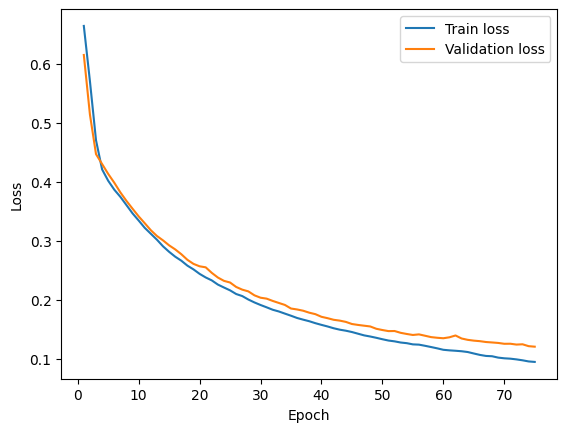

In [138]:
# Inizializza il modello, la funzione di perdita e l'ottimizzatore
input_size = fused_embeddings.shape[1]
num_classes = num_categories

model = FusionClassifier(input_size, num_classes)

criterion = torch.nn.BCEWithLogitsLoss()  # Per la classificazione multi-etichetta
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses = []
validation_losses = []

# Fase di addestramento
num_epochs = 75

for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_X.size(0)
    avg_loss = total_loss / len(train_dataset)

    train_losses.append(avg_loss)  # Salva la perdita di training

    # Validation phase
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            val_loss = criterion(outputs, batch_y)
            total_val_loss += val_loss.item() * batch_X.size(0)
    avg_val_loss = total_val_loss / len(test_dataset)
    validation_losses.append(avg_val_loss)  # Salva la perdita di validazione/test

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}")


plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(1, num_epochs + 1), train_losses, label='Train loss')
plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation loss')
plt.legend()
plt.show()

In [139]:
# Fase di predizione e valutazione

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        preds = torch.sigmoid(outputs).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(batch_y.cpu().numpy())

all_preds = np.vstack(all_preds)
all_targets = np.vstack(all_targets)

# Binarizza le predizioni con soglia 0.5
all_preds_binary = (all_preds >= 0.5).astype(int)

# Calcola l'F1 score
f1 = f1_score(all_targets, all_preds_binary, average='micro')
print(f"Test F1 Score: {f1:.4f}")

Test F1 Score: 0.9324


Epoch [1/50], Train Loss: 0.6180, Val Loss: 0.5283
Epoch [2/50], Train Loss: 0.4701, Val Loss: 0.4828
Epoch [3/50], Train Loss: 0.4429, Val Loss: 0.4674
Epoch [4/50], Train Loss: 0.4310, Val Loss: 0.4519
Epoch [5/50], Train Loss: 0.4285, Val Loss: 0.4483
Epoch [6/50], Train Loss: 0.4234, Val Loss: 0.4562
Epoch [7/50], Train Loss: 0.4241, Val Loss: 0.4501
Epoch [8/50], Train Loss: 0.4204, Val Loss: 0.4478
Epoch [9/50], Train Loss: 0.4169, Val Loss: 0.4468
Epoch [10/50], Train Loss: 0.4137, Val Loss: 0.4412
Epoch [11/50], Train Loss: 0.4145, Val Loss: 0.4398
Epoch [12/50], Train Loss: 0.4125, Val Loss: 0.4413
Epoch [13/50], Train Loss: 0.4089, Val Loss: 0.4407
Epoch [14/50], Train Loss: 0.4079, Val Loss: 0.4351
Epoch [15/50], Train Loss: 0.4061, Val Loss: 0.4310
Epoch [16/50], Train Loss: 0.4060, Val Loss: 0.4329
Epoch [17/50], Train Loss: 0.4023, Val Loss: 0.4377
Epoch [18/50], Train Loss: 0.4007, Val Loss: 0.4349
Epoch [19/50], Train Loss: 0.3985, Val Loss: 0.4341
Epoch [20/50], Train 

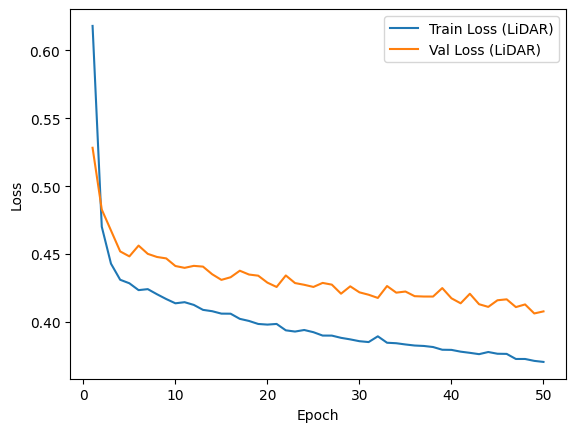

In [145]:
# Modello, ottimizzatore e funzione di perdita per LiDAR embeddings
input_size_lidar = lidar_embeddings.shape[1]
num_classes = label_vectors.shape[1]

model_lidar = Classifier(input_size_lidar, num_classes)
criterion = torch.nn.BCEWithLogitsLoss()  # Multi-label classification
optimizer = torch.optim.Adam(model_lidar.parameters(), lr=1e-3)

# Training e Validazione
num_epochs = 50
train_losses_lidar, val_losses_lidar = [], []

for epoch in range(num_epochs):
    model_lidar.train()
    total_loss = 0
    for batch_X, batch_y in train_loader_lidar:
        optimizer.zero_grad()
        outputs = model_lidar(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_X.size(0)
    avg_loss = total_loss / len(train_dataset_lidar)
    train_losses_lidar.append(avg_loss)

    # Validazione
    model_lidar.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in validation_loader_lidar:
            outputs = model_lidar(batch_X)
            val_loss = criterion(outputs, batch_y)
            total_val_loss += val_loss.item() * batch_X.size(0)
    avg_val_loss = total_val_loss / len(validation_dataset_lidar)
    val_losses_lidar.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Plot delle perdite
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(1, num_epochs + 1), train_losses_lidar, label='Train Loss (LiDAR)')
plt.plot(range(1, num_epochs + 1), val_losses_lidar, label='Val Loss (LiDAR)')
plt.legend()
plt.show()


Epoch [1/75], Train Loss: 0.4672, Val Loss: 0.3568
Epoch [2/75], Train Loss: 0.3067, Val Loss: 0.2660
Epoch [3/75], Train Loss: 0.2278, Val Loss: 0.2193
Epoch [4/75], Train Loss: 0.1852, Val Loss: 0.1876
Epoch [5/75], Train Loss: 0.1531, Val Loss: 0.1619
Epoch [6/75], Train Loss: 0.1303, Val Loss: 0.1401
Epoch [7/75], Train Loss: 0.1165, Val Loss: 0.1295
Epoch [8/75], Train Loss: 0.1083, Val Loss: 0.1216
Epoch [9/75], Train Loss: 0.0931, Val Loss: 0.1112
Epoch [10/75], Train Loss: 0.0848, Val Loss: 0.0991
Epoch [11/75], Train Loss: 0.0799, Val Loss: 0.0925
Epoch [12/75], Train Loss: 0.0658, Val Loss: 0.0913
Epoch [13/75], Train Loss: 0.0609, Val Loss: 0.0829
Epoch [14/75], Train Loss: 0.0585, Val Loss: 0.0846
Epoch [15/75], Train Loss: 0.0530, Val Loss: 0.0772
Epoch [16/75], Train Loss: 0.0467, Val Loss: 0.0755
Epoch [17/75], Train Loss: 0.0423, Val Loss: 0.0748
Epoch [18/75], Train Loss: 0.0423, Val Loss: 0.0792
Epoch [19/75], Train Loss: 0.0382, Val Loss: 0.0689
Epoch [20/75], Train 

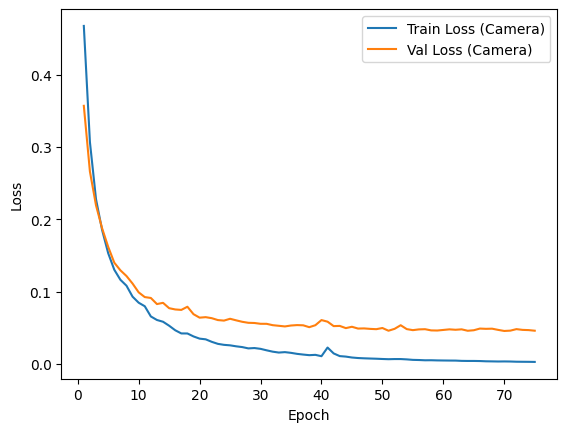

In [141]:
# Modello, ottimizzatore e funzione di perdita per Camera embeddings
input_size_camera = camera_embeddings.shape[1]

model_camera = Classifier(input_size_camera, num_classes)
optimizer_camera = torch.optim.Adam(model_camera.parameters(), lr=1e-3)

# Training e Validazione
train_losses_camera, val_losses_camera = [], []

for epoch in range(num_epochs):
    model_camera.train()
    total_loss = 0
    for batch_X, batch_y in train_loader_camera:
        optimizer_camera.zero_grad()
        outputs = model_camera(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer_camera.step()
        total_loss += loss.item() * batch_X.size(0)
    avg_loss = total_loss / len(train_dataset_camera)
    train_losses_camera.append(avg_loss)

    # Validazione
    model_camera.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in validation_loader_camera:
            outputs = model_camera(batch_X)
            val_loss = criterion(outputs, batch_y)
            total_val_loss += val_loss.item() * batch_X.size(0)
    avg_val_loss = total_val_loss / len(validation_dataset_camera)
    val_losses_camera.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Plot delle perdite
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(1, num_epochs + 1), train_losses_camera, label='Train Loss (Camera)')
plt.plot(range(1, num_epochs + 1), val_losses_camera, label='Val Loss (Camera)')
plt.legend()
plt.show()


In [146]:

# Predizione e valutazione per LiDAR
model_lidar.eval()
all_preds_lidar, all_targets_lidar = [], []
with torch.no_grad():
    for batch_X, batch_y in DataLoader(test_dataset_lidar, batch_size=batch_size):
        outputs = model_lidar(batch_X)
        preds = torch.sigmoid(outputs).cpu().numpy()
        all_preds_lidar.append(preds)
        all_targets_lidar.append(batch_y.cpu().numpy())

all_preds_lidar = np.vstack(all_preds_lidar)
all_targets_lidar = np.vstack(all_targets_lidar)
all_preds_binary_lidar = (all_preds_lidar >= 0.5).astype(int)

f1_lidar = f1_score(all_targets_lidar, all_preds_binary_lidar, average='micro')
print(f"Test F1 Score (LiDAR): {f1_lidar:.4f}")

# Predizione e valutazione per Camera
model_camera.eval()
all_preds_camera, all_targets_camera = [], []
with torch.no_grad():
    for batch_X, batch_y in DataLoader(test_dataset_camera, batch_size=batch_size):
        outputs = model_camera(batch_X)
        preds = torch.sigmoid(outputs).cpu().numpy()
        all_preds_camera.append(preds)
        all_targets_camera.append(batch_y.cpu().numpy())

# Converti i risultati in array NumPy
all_preds_camera = np.vstack(all_preds_camera)
all_targets_camera = np.vstack(all_targets_camera)

# Binarizza le predizioni con soglia 0.5
all_preds_binary_camera = (all_preds_camera >= 0.5).astype(int)

# Calcola l'F1 score per Camera embeddings
f1_camera = f1_score(all_targets_camera, all_preds_binary_camera, average='micro')
print(f"Test F1 Score (Camera): {f1_camera:.4f}")



Test F1 Score (LiDAR): 0.6915
Test F1 Score (Camera): 0.9707
